# การทำนายลักษณะกลุ่มโรคของพืช โดยใช้ Plant Disease Model

ตัวอย่างนี้จะเป็นการทำนายลักษณะกลุ่มโรคของพืช (Plant Disease) จากรูปภาพใบไม้ โดยใช้โครงสร้างโมเดลแบบ CNN ซึ่งจากโมเดลที่พัฒนาขึ้น ทำให้เราสามารถกำหนดตำแหน่งจุดที่สำคัญบนรูปภาพ เพื่อใช้ในการทำนายลักษณะกลุ่มโรคของพืช 
ซึ่งเครื่องมือจากโมเดลดังกล่าวนี้ สามารถทำนายลักษณะของกลุ่มโรคในพืชแต่ละชนิดได้ทั้งหมด 39 รูปแบบ โดยแต่ละท่าทางที่ทำนายได้ 

<br>

ซึ่งขั้นตอนการนำภาพถ่ายมาผ่านโปรแกรมทำนายลักษณะกลุ่มโรคของพืชได้สรุปเอาไว้ 5 ขั้นตอน ดังนี้
<br><br>
![plant_workflow.jpg](https://raw.github.com/hengkp/microbit_ml_examples/main/plant%20disease%20prediction/plant_workflow.jpg)
<br><br>

โดยมีรายละเอียดพร้อมตัวอย่างโค้ดในขั้นตอนต่าง ๆ คือ<br>
**ขั้นตอนที่ 1** เตรียมชุดรูปภาพสำหรับเทรนโมเดล<br>
**ขั้นตอนที่ 2** นำเข้าและเตรียมโมเดล<br>
**ขั้นตอนที่ 3** เทรนโมเดลด้วยชุดรูปภาพที่เตรียมไว้<br>
**ขั้นตอนที่ 4** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้้<br>
**ขั้นตอนที่ 5** แสดงผลการทำนายลักษณะกลุ่มโรคของพืชจากรูปใบไม้<br>

In [7]:
#@title **ขั้นตอนที่ 1** เตรียมชุดรูปภาพสำหรับเทรนโมเดล
#@markdown เป็นขั้นตอนการดาวน์โหลดชุดข้อมูลจาก https://data.mendeley.com/datasets/tywbtsjrjv/1 ซึ่งเป็นชุดข้อมูลที่ Tensorflow นำมาใช้ในการเทรนโมเดล
#@markdown สามารถกดรันเพื่อดาวน์โหลดโฟลเดอร์ **Plant_leave_diseases_dataset_with_augmentation** และจัดเรียงรูปตามกลุ่มเพื่อใช้สำหรับการเทรนโมเดล

import os
import shutil
import urllib.request
import gdown
import zipfile
import tensorflow as tf

# ฟังก์ชั่นสำหรับแตกไฟล์ ZIP
def extract_zip(filepath):
  with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall()

# ฟังก์ชั่นสำหรับลบโฟลเดอร์
def remove_folder(path):
    shutil.rmtree(path)

# ฟังก์ชั่นสำหรับลบไฟล์
def remove_file(file_path):
    os.remove(file_path)

# ดาวน์โหลดโฟลเดอร์ชุดข้อมูลทั้งหมด
url = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/tywbtsjrjv-1.zip'
filename = 'tywbtsjrjv-1.zip'
urllib.request.urlretrieve(url, filename)
extract_zip(filename)
remove_file(filename)

# แยกเฉพาะไฟล์รูปที่ต้องการเพื่อใช้เทรนโมเดล
folder_dir = 'Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network'
folder_filename = 'Plant_leaf_diseases_dataset_with_augmentation.zip'
folder_path = os.path.join(folder_dir,folder_filename)
extract_zip(folder_path)
remove_folder(folder_dir)

# กำหนดชื่อของแต่ละกลุ่ม
folder_name = 'Plant_leave_diseases_dataset_with_augmentation'
class_names = os.listdir(folder_name)
num_classes = len(class_names)

# กำหนดขนาดรูป
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

# กำหนดค่าการรันเทรนโมเดล
batch_size = 32
epochs = 25

# เตรียมชุดข้อมูล
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

# นำภาพที่ต้องการมาใส่ในชุดข้อมูลที่เตรียมไว้
train_dataset = data_gen.flow_from_directory(directory=folder_name, 
                                             target_size=target_size, 
                                             batch_size=batch_size, 
                                             class_mode='categorical', 
                                             classes=class_names)

train_dataset

Found 61486 images belonging to 39 classes.


In [8]:
#@title **ขั้นตอนที่ 2** นำเข้าและเตรียมโมเดล
#@markdown เขียนโมเดลสำหรับการทำนายลักษณะกลุ่มโรคของพืชจากรูปใบไม้โดยใช้โมเดลเริ่มต้น ImageNet V2 และปรับแต่งผลลัพธ์เพื่อให้สามารถจำแนกกลุ่มของโรคได้

import os
import tensorflow as tf

# เตรียมโมเดลพื้นฐาน
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# ตั้งค่าโมเดลพื้นฐานไม่ให้สามารถเปลี่ยนแปลงได้
for layer in base_model.layers:
    layer.trainable = False

# ปรับแต่งโมเดลโดยเพิ่มขั้นตอนการแยกกลุ่ม เพื่อให้ได้ผลลัพท์ตามจำนวนที่กำหนด
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# กำหนดค่าฟังก์ชั่นที่จำเป็นต่อการเทรนโมเดล
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 39)                49959     
                                                                 
Total params: 2,307,943
Trainable params: 49,959
Non-trainable params: 2,257,984
____________________________________________

In [ ]:
#@title **ขั้นตอนที่ 3** เทรนโมเดลด้วยชุดรูปภาพที่เตรียมไว้
#@markdown กดรันเพื่อเริ่มการเทรนโมเดล โดยขั้นตอนนี้จะใช้เวลานานเพื่อประมวลผลเนื่องจากปริมาณของรูปที่ใช้มีจำนวนมาก <br>
#@markdown ผู้เรียนสามารถข้ามขั้นตอนนี้ได้ โดยกดรันขั้นตอนต่อไปแทน ซึ่งเป็นขั้นตอนการนำเข้าโมเดลที่ผ่านการเทรนแล้วมาจากอินเตอร์เน็ต

history = model.fit(train_dataset, 
                    epochs=epochs, 
                    steps_per_epoch=len(train_dataset),
                    verbose=2)

# บันทึกโมเดลที่ผ่านการเทรนแล้ว
model.save('plant_disease_model.h5')

Epoch 1/25


In [ ]:
#@title **ขั้นตอนเสริม** การนำเข้าโมเดลที่เก็บไว้ในโฟลเดอร์ Google Drive
#@markdown กดรันเพื่อนำเข้าโมเดลจากไฟล์ **plant_disease_model.h5**

# ดาวน์โหลดไฟล์โมเดล
url = 'https://drive.google.com/file/d/1NkrgjMF14M3hvTZXoEqLyIzCHkT6GnAB/view?usp=sharing'
filename = 'plant_disease_model.h5'
gdown.download(url, filename)

# นำเข้าโมเดล
model = tf.keras.models.load_model('plant_disease_model.h5')

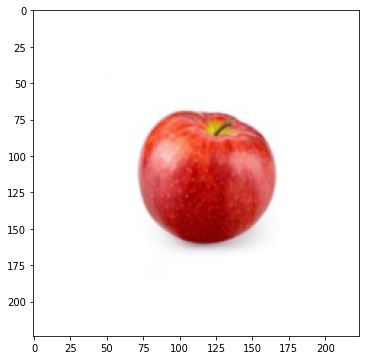

In [ ]:
#@title **ขั้นตอนที่ 4** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้
#@markdown กดรันเพื่อนำเข้ารูปตัวอย่างที่ต้องการทำนายผลและทำนายผล

from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import io

# ใส่ที่อยู่ของภาพที่ต้องการนำเข้า
image_path = "Plant_leave_diseases_dataset_with_augmentation/Apple___healthy/image (1).JPG"

# นำเข้าและปรับขนาดภาพให้สอดคล้องกับความต้องการของโมเดล
img = io.imread(image_path) 
img = cv2.resize(img, target_size) # resize to match inputs of model

# ปรับลักษณะของรูปให้สอดคล้องกับความต้องการของโมเดล
img_input = img / 255.0
img_input = np.expand_dims(img_input, axis=0)

# ประมวลผลภาพ
prediction = model.predict(img_input, verbose=0)

# ดึงข้อมูลพิกัดที่สำคัญที่ได้จากผลการประมวล
class_index = np.argmax(prediction[0])
class_name = list(class_names)[class_index]

# เตรียมรูปภาพเพื่อแสดงผล
if np.max(img) <= 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(6, 6)) # define size of figure

# ใส่รูปภาพ
plt.imshow(img)

# ใส่ชื่อวัตถุลงในภาพ
text = class_name + " ({:.2f})".format(prediction[0][class_index])
ax.annotate(text, (3, 220), fontsize=24, color="red")

# แสดงผลรูปภาพพร้อมพิกัด
plt.show()

In [ ]:
#@title **ขั้นตอนที่ 5** แสดงผลการทำนายลักษณะกลุ่มโรคของพืชจากรูปใบไม้
#@markdown กดรันเพื่อแสดงผลการทำนาย

# แสดงผลชื่อกลุ่มของวัตถุนั้น
text = class_name + " ({:.2f})".format(prediction[0][class_index])
print("Predicted Class:", text)

Predicted Class: apple (0.92)
